# Enhanced Stock Index Prediction using Deep Learning Models

This notebook implements LSTM, GRU, and RNN models to predict the future prices of SP500 and IBEX35 indices using enhanced features including economic indicators, technical analysis, and seasonality decomposition.

## 1. Importing Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import ta
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from arch import arch_model

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Collection

We'll download data for SP500 and IBEX35 indices from Yahoo Finance and economic data from FRED.

In [3]:
# Define the symbols of the indices
sp500_ticker = "^GSPC"  # S&P 500
ibex35_ticker = "^IBEX"  # IBEX 35

# Define the date range
start_date = "2000-01-01"
end_date = "2024-01-01"

# Download historical data from Yahoo Finance
if not os.path.exists("sp500_data.csv") or not os.path.exists("ibex35_data.csv"):
    print("Downloading data from Yahoo Finance...")
    sp500_data = yf.download(sp500_ticker).history(period='1d', start=start_date, end=end_date)
    ibex35_data = yf.download(ibex35_ticker, start=start_date, end=end_date)

    # Save the data to CSV
    sp500_data.to_csv("sp500_data.csv")
    ibex35_data.to_csv("ibex35_data.csv")

    print("Data downloaded and saved to CSV files.")
else:
    sp500_data = pd.read_csv("sp500_data.csv", index_col="Date", parse_dates=True)
    ibex35_data = pd.read_csv("ibex35_data.csv", index_col="Date", parse_dates=True)

In [4]:
# Display the first few rows of each dataset
print("S&P 500 Data:")
print(sp500_data.head())
print("\nIBEX 35 Data:")
print(ibex35_data.head())

S&P 500 Data:
                  Close         High          Low         Open      Volume
Date                                                                      
2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000   931800000
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971  1009000000
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044  1085500000
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985  1092300000
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951  1225200000

IBEX 35 Data:
                   Close          High           Low          Open  Volume
Date                                                                      
2000-01-03  11609.988281  11881.787812  11574.388708  11641.388640       0
2000-01-04  11206.587891  11529.987943  11159.788135  11529.987943       0
2000-01-05  10863.088867  11068.088664  10824.889686  11068.088664       0
2000-01-07  11102.388672  11137.888634  10882.688708  10882.688708     

## 3. Collecting Economic Data from FRED

We'll collect economic indicators from the Federal Reserve Economic Data (FRED) to enhance our prediction models.

In [5]:
# FRED API Key
FRED_API_KEY = "144e929e4cb64cc8c55902991441556b"

# Economic factors to collect
economic_factors = ["DFF", "T10YIE", "DCOILWTICO", "VIXCLS", "DEXUSEU", "NASDAQCOM", "DHHNGSP", 
                    "BAMLC0A0CMEY", "USEPUINDXD", "DPRIME", "DEXCAUS", "DEXDNUS", "DEXJPUS", "DEXCHUS", "DEXSZUS",
                    "DEXUSAL", "DEXUSUK", "DEXKOUS", "INFECTDISEMVTRACKD", "DCOILBRENTEU", "DEXMXUS"]

# Rename mapping for better readability
rename_map = {"DFF":"daily_fed_funds", "T10YIE":"ten_year_breakeven_inflation", "DCOILWTICO":"WTI_crude_oil_price", 
              "VIXCLS":"VIX", "DEXUSEU":"USD$EUR_spot", "NASDAQCOM":"NASDAQ", "DHHNGSP":"henry_hub_natrual_gas",
              "BAMLC0A0CMEY":"corporate_bond_yield", "USEPUINDXD":"economic_policy_uncertainty", "DPRIME":"prime_rate",
              "DEXCAUS":"USD$CAD_spot", "DEXDNUS":"USD$CNY_spot", "DEXJPUS":"USD$JPY_spot", "DEXCHUS":"USD$CHF_spot", 
              "DEXSZUS":"USD$SEK_spot", "DEXUSAL":"USD$AUD_spot", "DEXUSUK":"USD$GBP_spot", "DEXKOUS":"USD$KRW_spot", 
              "INFECTDISEMVTRACKD":"infectious_disease", "DCOILBRENTEU":"Brent_crude_oil_price_europe", "DEXMXUS":"USD$MXN_spot"}

In [6]:
# Check if economic data already exists
if os.path.exists('economic_data.csv'):
    print("Loading economic data from CSV file...")
    df_total = pd.read_csv('economic_data.csv')
    df_total['date'] = pd.to_datetime(df_total['date'])
else:
    print("Downloading economic data from FRED...")
    # Pull the FRED data for daily economic variables
    df_total = pd.DataFrame()
    
    for series in economic_factors:
        curr_start, curr_end = start_date, "2005-01-01"
        series_df = pd.DataFrame()
        # getting a given series
        while curr_start <= end_date:
            base_series_url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series}&api_key={FRED_API_KEY}&file_type=json&observation_start={curr_start}&observation_end={curr_end}&units=lin&frequency=d"
            response = requests.get(base_series_url)
            data = response.json()
            df = pd.json_normalize(data)
            observations = pd.json_normalize(df['observations'][0])
            series_df = pd.concat([series_df, observations], axis=0)
            curr_start = (pd.to_datetime(curr_end) + relativedelta(days=1)).strftime("%Y-%m-%d")
            curr_end = min((pd.to_datetime(curr_end) + relativedelta(years=5, days=1), pd.to_datetime(end_date))).strftime("%Y-%m-%d")
            time.sleep(1)
        
        # renaming columns
        series_df.rename(columns={"date":"date", "value":rename_map[series]}, inplace=True)
        series_df.drop(columns=["realtime_start", "realtime_end"], inplace=True)
        
        if df_total.empty:
            df_total = series_df
        else:
            df_total = pd.merge(df_total, series_df, on=['date'], how='inner', validate='1:1')
    
    # Save to CSV
    df_total.to_csv('economic_data.csv', index=False)
    print("Economic data downloaded and saved to CSV.")

Loading economic data from CSV file...


In [7]:
# Display the first few rows of economic data
print("Economic Data:")
print(df_total.head())

Economic Data:
        date  daily_fed_funds ten_year_breakeven_inflation  \
0 2003-01-02             1.30                         1.64   
1 2003-01-03             1.12                         1.62   
2 2003-01-06             1.22                         1.63   
3 2003-01-07             1.20                         1.62   
4 2003-01-08             1.29                         1.71   

  WTI_crude_oil_price    VIX USD$EUR_spot   NASDAQ henry_hub_natrual_gas  \
0               31.97  25.39       1.0361  1384.85                  4.93   
1               33.26  24.68       1.0418  1387.08                  5.13   
2               32.29  24.91       1.0469  1421.32                  4.94   
3               31.20  25.13       1.0419  1431.57                  4.89   
4               30.66  25.53       1.0447  1401.07                  5.07   

  corporate_bond_yield  economic_policy_uncertainty  ... USD$CNY_spot  \
0                 5.26                       324.67  ...       7.1684   
1        

## 4. Feature Engineering and Technical Analysis

We'll add technical indicators and perform feature engineering to enhance our prediction models.

In [8]:
# Load and preprocess IBEX 35 data
ibex = pd.read_csv('ibex35_data.csv')
ibex = ta.add_all_ta_features(ibex, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
ibex.index = pd.to_datetime(ibex['Date'])
ibex.drop(columns=['Date'], inplace=True)

# Load and preprocess S&P 500 data
sp500 = pd.read_csv('sp500_data.csv')
sp500 = ta.add_all_ta_features(sp500, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
sp500.index = pd.to_datetime(sp500['Date'])
sp500.drop(columns=['Date'], inplace=True)

In [9]:
# Calculate percentage changes and add month, day, year columns
# IBEX 35
ibex['pct_change'] = ibex['Close'].pct_change() * 100  # Percentage change in Close
ibex['month'] = ibex.index.month
ibex['day'] = ibex.index.day
ibex['year'] = ibex.index.year

# S&P 500
sp500['pct_change'] = sp500['Close'].pct_change() * 100  # Percentage change in Close
sp500['month'] = sp500.index.month
sp500['day'] = sp500.index.day
sp500['year'] = sp500.index.year

# Drop NaNs from percentage changes
ibex = ibex.dropna()
sp500 = sp500.dropna()

## 5. Seasonality Decomposition

We'll decompose the time series to remove seasonality and improve our predictions.

In [10]:
# Define shift values to handle negative values for multiplicative decomposition of pct_change
shift_value_ibex = abs(ibex['pct_change'].min()) + 1
ibex['pct_change_shifted'] = ibex['pct_change'] + shift_value_ibex

shift_value_sp500 = abs(sp500['pct_change'].min()) + 1
sp500['pct_change_shifted'] = sp500['pct_change'] + shift_value_sp500

In [11]:
# Function to decompose and remove multiplicative seasonality using seasonal_decompose (Classic)
def decompose_and_remove_seasonality_classic(series, title, period, freq_label, shift_value):
    # Decompose the series using a multiplicative model
    decomposition = seasonal_decompose(series, model='multiplicative', period=period)
    
    # Remove the seasonal component
    deseasonalized = series / decomposition.seasonal
    
    # Shift back to original scale
    deseasonalized_unshifted = deseasonalized - shift_value
    
    # Plot the original series, trend, seasonal component, and deseasonalized series
    plt.figure(figsize=(12, 8))
    
    plt.subplot(411)
    plt.plot(series - shift_value, label='Original')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Classic Multiplicative Decomposition (Period: {freq_label})')
    
    plt.subplot(412)
    plt.plot(decomposition.trend - shift_value, label='Trend')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal Component')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(deseasonalized_unshifted, label='Deseasonalized')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return decomposition, deseasonalized_unshifted

In [12]:
# Function to decompose and remove seasonality using STL (modified to return trend + residual)
def decompose_and_remove_seasonality_stl(series, title, period, freq_label, shift_value=None, model='multiplicative'):
    # Decompose the series using STL
    stl = STL(series, period=period, seasonal=13)  # seasonal=13 ensures a smooth seasonal component
    decomposition = stl.fit()
    
    # Remove the seasonal component
    if model == 'multiplicative':
        # For multiplicative model: deseasonalized = trend * residual
        deseasonalized = series / decomposition.seasonal
    else:
        # For additive model: deseasonalized = trend + residual
        deseasonalized = series - decomposition.seasonal
    
    # If shift_value is provided, shift back to original scale
    if shift_value is not None:
        deseasonalized_unshifted = deseasonalized - shift_value
        series_unshifted = series - shift_value
    else:
        deseasonalized_unshifted = deseasonalized
        series_unshifted = series
    
    # Plot the original series, trend, seasonal component, and deseasonalized series
    plt.figure(figsize=(12, 8))
    
    plt.subplot(411)
    plt.plot(series_unshifted, label='Original')
    plt.legend(loc='upper left')
    plt.title(f'{title} - STL Decomposition (Period: {freq_label})')
    
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal Component')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(deseasonalized_unshifted, label='Deseasonalized (Trend + Residual)')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return decomposition, deseasonalized_unshifted

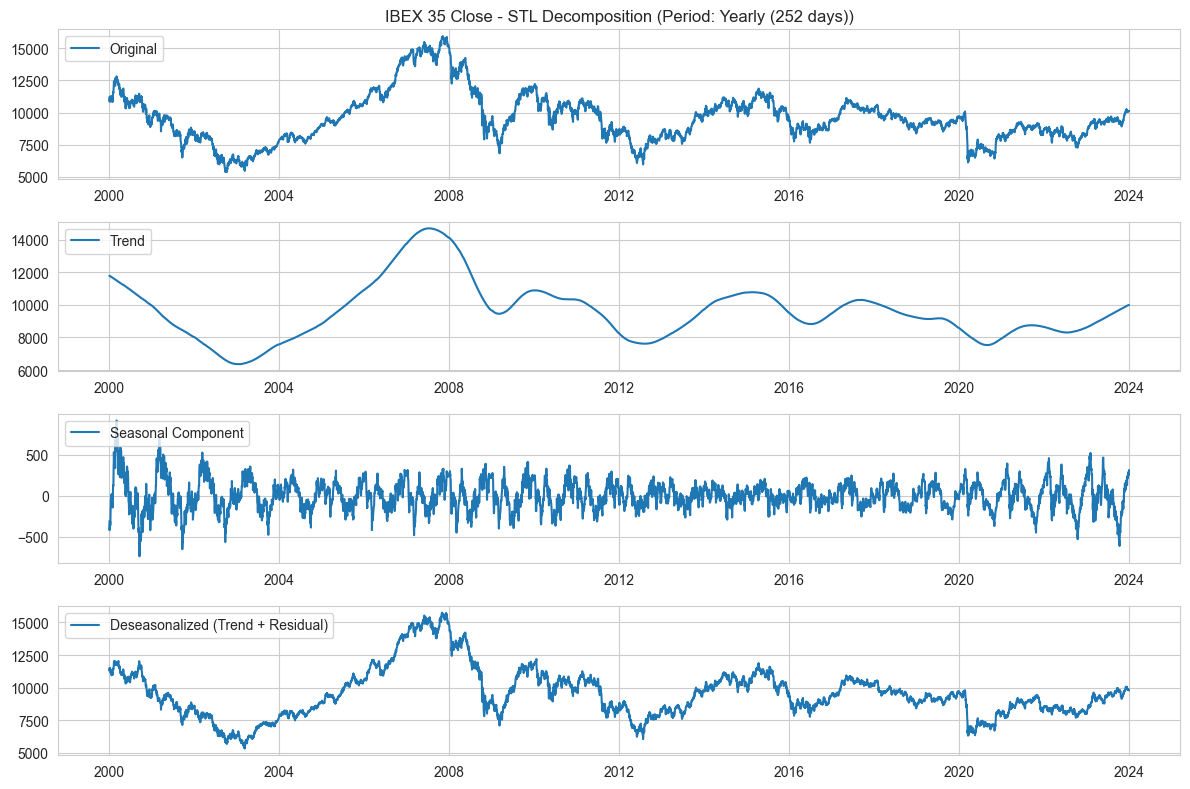

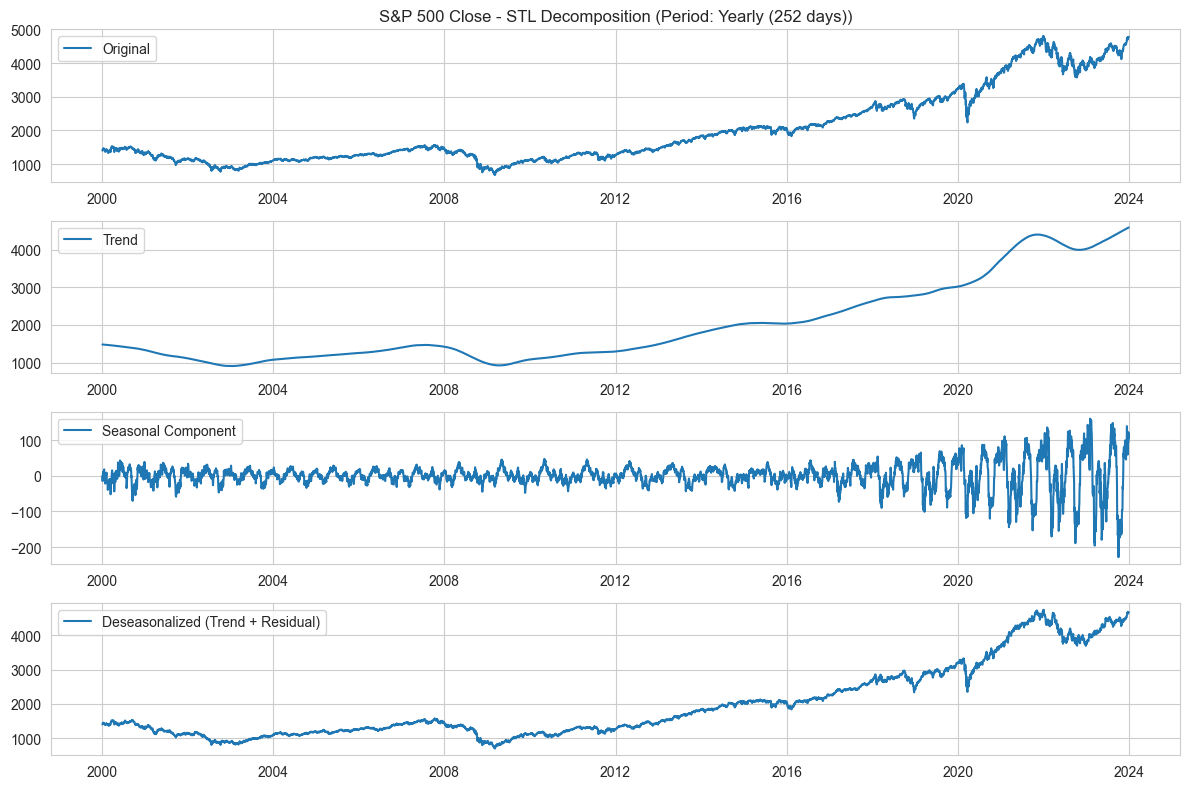

In [13]:
# Apply STL decomposition to Close prices
# Perform STL decomposition on the Close prices (no shift needed since Close is positive)
ibex_decomp_close_yearly_stl, ibex_close_deseasonalized_yearly_stl = decompose_and_remove_seasonality_stl(
    ibex['Close'], 'IBEX 35 Close', period=252, freq_label='Yearly (252 days)', shift_value=None, model='additive'
)
# Use the deseasonalized series (trend + residual) as the seasonally adjusted Close
ibex['Close_deseasonalized'] = ibex_close_deseasonalized_yearly_stl

sp500_decomp_close_yearly_stl, sp500_close_deseasonalized_yearly_stl = decompose_and_remove_seasonality_stl(
    sp500['Close'], 'S&P 500 Close', period=252, freq_label='Yearly (252 days)', shift_value=None, model='additive'
)
# Use the deseasonalized series (trend + residual) as the seasonally adjusted Close
sp500['Close_deseasonalized'] = sp500_close_deseasonalized_yearly_stl

In [14]:
# Recalculate percentage changes based on the deseasonalized Close (trend + residual)
ibex['pct_change_deseasonalized'] = ibex['Close_deseasonalized'].pct_change() * 100
sp500['pct_change_deseasonalized'] = sp500['Close_deseasonalized'].pct_change() * 100

# Drop NaNs from the new percentage changes
ibex = ibex.dropna()
sp500 = sp500.dropna()

## 6. Merging Data and Creating Additional Features

In [15]:
# Prepare economic data
econ = df_total.copy()
econ.rename(columns={'date':'Date'}, inplace=True)
econ.index = pd.to_datetime(econ['Date'])
econ.drop(columns=['Date'], inplace=True)
for col in econ.select_dtypes(include='object'):
    econ[col] = pd.to_numeric(econ[col], errors='coerce')

In [16]:
# Merge SP500 and IBEX35 data
df = pd.merge(sp500, ibex, how='inner', left_index=True, right_index=True, suffixes=["_sp500", "_ibex"], validate='1:1')

# Merge with economic data
df = pd.merge(df, econ, how='inner', left_index=True, right_index=True, validate='1:1')

In [17]:
# Clean up and rename columns
pct_change_cols = [col for col in df.columns if 'pct_change' in col and 'deseasonalized' in col]
df.drop(columns=['Close_sp500', 'Close_ibex'] + pct_change_cols, inplace=True)
df.rename(columns={'Close_deseasonalized_sp500':'Close_sp500', 'Close_deseasonalized_ibex':'Close_ibex', 'pct_change_sp500':'SP500_Returns', 'pct_change_ibex':'IBEX35_Returns'}, inplace=True)

# Deseasonalizing the returns
df['SP500_Returns'] = df['Close_sp500'].pct_change() * 100
df['IBEX35_Returns'] = df['Close_ibex'].pct_change() * 100

# Create target variables (next day returns)
df['SP500_Returns_Next'] = df['SP500_Returns'].shift(-1)
df['IBEX35_Returns_Next'] = df['IBEX35_Returns'].shift(-1)

/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/2329789231.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SP500_Returns_Next'] = df['SP500_Returns'].shift(-1)
/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/2329789231.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['IBEX35_Returns_Next'] = df['IBEX35_Returns'].shift(-1)


In [18]:
# Create lagged features
for lag in [1, 2, 3, 5, 7, 14]:
    df[f'SP500_Returns_Lag{lag}'] = df['SP500_Returns'].shift(lag)
    df[f'IBEX35_Returns_Lag{lag}'] = df['IBEX35_Returns'].shift(lag)

# Create rolling statistics
df['SP500_Rolling_Mean_5'] = df['SP500_Returns'].rolling(window=5).mean()
df['SP500_Rolling_Vol_5'] = df['SP500_Returns'].rolling(window=5).std()
df['IBEX35_Rolling_Mean_5'] = df['IBEX35_Returns'].rolling(window=5).mean()
df['IBEX35_Rolling_Vol_5'] = df['IBEX35_Returns'].rolling(window=5).std()

# Create lagged economic features
econ_cols = econ.columns.tolist()
for col in econ_cols:
    df[f'{col}_Lag1'] = df[col].shift(1)

/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/1563653460.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'SP500_Returns_Lag{lag}'] = df['SP500_Returns'].shift(lag)
/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/1563653460.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'IBEX35_Returns_Lag{lag}'] = df['IBEX35_Returns'].shift(lag)
/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/1563653460.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually

In [19]:
# Add BIAS indicator
df['SP500_BIAS'] = (df['Close_sp500'] - df['Close_sp500'].rolling(window=12).mean()) / df['Close_sp500'].rolling(window=12).mean() * 100
df['IBEX35_BIAS'] = (df['Close_ibex'] - df['Close_ibex'].rolling(window=12).mean()) / df['Close_ibex'].rolling(window=12).mean() * 100

# Add PSY (Psychological Line Indicator)
def calculate_psy(price, period=12):
    returns = price.pct_change()
    psy = (returns > 0).rolling(window=period).sum() / period * 100
    return psy

df['SP500_PSY'] = calculate_psy(df['Close_sp500'])
df['IBEX35_PSY'] = calculate_psy(df['Close_ibex'])

/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/473771129.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SP500_BIAS'] = (df['Close_sp500'] - df['Close_sp500'].rolling(window=12).mean()) / df['Close_sp500'].rolling(window=12).mean() * 100
/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/473771129.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['IBEX35_BIAS'] = (df['Close_ibex'] - df['Close_ibex'].rolling(window=12).mean()) / df['Close_ibex'].rolling(window=12).mean() * 100
/var/fol

In [20]:
# Add GARCH volatility
try:
    # Fit GARCH model for SP500
    garch_model_sp500 = arch_model(df['SP500_Returns'].dropna(), vol='Garch', p=1, q=1)
    garch_fit_sp500 = garch_model_sp500.fit(disp='off')
    df['SP500_GARCH_Vol'] = pd.Series(garch_fit_sp500.conditional_volatility, index=garch_fit_sp500.conditional_volatility.index)
    
    # Fit GARCH model for IBEX35
    garch_model_ibex35 = arch_model(df['IBEX35_Returns'].dropna(), vol='Garch', p=1, q=1)
    garch_fit_ibex35 = garch_model_ibex35.fit(disp='off')
    df['IBEX35_GARCH_Vol'] = pd.Series(garch_fit_ibex35.conditional_volatility, index=garch_fit_ibex35.conditional_volatility.index)
except Exception as e:
    print(f"Error fitting GARCH model: {e}")
    # If GARCH fitting fails, use rolling volatility as a substitute
    df['SP500_GARCH_Vol'] = df['SP500_Returns'].rolling(window=22).std()
    df['IBEX35_GARCH_Vol'] = df['IBEX35_Returns'].rolling(window=22).std()

/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/3026691493.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SP500_GARCH_Vol'] = pd.Series(garch_fit_sp500.conditional_volatility, index=garch_fit_sp500.conditional_volatility.index)
/var/folders/ds/nrh7s8yd7wj_n0lgd7w4qvcr0000gn/T/ipykernel_37310/3026691493.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['IBEX35_GARCH_Vol'] = pd.Series(garch_fit_ibex35.conditional_volatility, index=garch_fit_ibex35.conditional_volatility.index)


In [21]:
# Clean up the dataframe
df = df.dropna(axis=1, how='all').dropna(axis=0, how='any')
print(f"Final dataframe shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 2}")  # Subtract 2 for the target variables

Final dataframe shape: (5020, 258)
Number of features: 256


## 7. Data Preparation for Deep Learning Models

In [22]:
# Function to create sequences for time series forecasting
def create_sequences(data, seq_length):
    """
    Create sequences of data for time series forecasting.
    
    Parameters:
    data (numpy.ndarray): Input data array
    seq_length (int): Length of each sequence
    
    Returns:
    tuple: (X, y) where X is the input sequences and y is the target values
    """
    X, y_sp500, y_ibex35 = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-2])  # All features except the target variables
        y_sp500.append(data[i+seq_length, -2])  # SP500_Returns_Next
        y_ibex35.append(data[i+seq_length, -1])  # IBEX35_Returns_Next
    return np.array(X), np.array(y_sp500), np.array(y_ibex35)

In [23]:
# Prepare data for deep learning models
def prepare_data(data, seq_length=60, test_size=0.2):
    
    """
    Prepare data for deep learning models.
    
    Parameters:
    data (pandas.DataFrame): Input data
    seq_length (int): Length of each sequence
    test_size (float): Proportion of data to use for testing
    
    Returns:
    tuple: (X_train, X_test, y_train_sp500, y_test_sp500, y_train_ibex35, y_test_ibex35, scaler)
    """
    # Convert to numpy array
    data_values = data.values
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_values)
    
    # Create sequences
    X, y_sp500, y_ibex35 = create_sequences(data_scaled, seq_length)
    
    # Split into training and testing sets
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train_sp500, y_test_sp500 = y_sp500[:split_idx], y_sp500[split_idx:]
    y_train_ibex35, y_test_ibex35 = y_ibex35[:split_idx], y_ibex35[split_idx:]
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train_sp500 = torch.FloatTensor(y_train_sp500).reshape(-1, 1)
    y_test_sp500 = torch.FloatTensor(y_test_sp500).reshape(-1, 1)
    y_train_ibex35 = torch.FloatTensor(y_train_ibex35).reshape(-1, 1)
    y_test_ibex35 = torch.FloatTensor(y_test_ibex35).reshape(-1, 1)
    
    return X_train, X_test, y_train_sp500, y_test_sp500, y_train_ibex35, y_test_ibex35, scaler

In [24]:
# Prepare data for deep learning models
seq_length = 30  # Use 30 days of data to predict the next day

# Prepare data
X_train, X_test, y_train_sp500, y_test_sp500, y_train_ibex35, y_test_ibex35, scaler = prepare_data(
    df, seq_length=seq_length
)


# Print the shapes of the data
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train_sp500: {y_train_sp500.shape}, y_test_sp500: {y_test_sp500.shape}")
print(f"y_train_ibex35: {y_train_ibex35.shape}, y_test_ibex35: {y_test_ibex35.shape}")

X_train: torch.Size([3992, 30, 256]), X_test: torch.Size([998, 30, 256])
y_train_sp500: torch.Size([3992, 1]), y_test_sp500: torch.Size([998, 1])
y_train_ibex35: torch.Size([3992, 1]), y_test_ibex35: torch.Size([998, 1])


In [25]:
# Create DataLoader for batch processing
def create_dataloader(X, y, batch_size=32, shuffle=True):
    """
    Create DataLoader for batch processing.
    
    Parameters:
    X (torch.Tensor): Input data
    y (torch.Tensor): Target data
    batch_size (int): Batch size
    shuffle (bool): Whether to shuffle the data
    
    Returns:
    torch.utils.data.DataLoader: DataLoader object
    """
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Create DataLoaders
batch_size = 32

train_loader_sp500 = create_dataloader(X_train, y_train_sp500, batch_size=batch_size)
test_loader_sp500 = create_dataloader(X_test, y_test_sp500, batch_size=batch_size, shuffle=False)

train_loader_ibex35 = create_dataloader(X_train, y_train_ibex35, batch_size=batch_size)
test_loader_ibex35 = create_dataloader(X_test, y_test_ibex35, batch_size=batch_size, shuffle=False)

## 8. LSTM Model Implementation

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        """
        LSTM model for time series forecasting.
        
        Parameters:
        input_size (int): Number of features in the input
        hidden_size (int): Number of features in the hidden state
        num_layers (int): Number of recurrent layers
        output_size (int): Number of features in the output
        dropout (float): Dropout probability
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        
        return out

In [27]:
# Function to train the model
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100, early_stopping_patience=10):
    """
    Train the model.
    
    Parameters:
    model (torch.nn.Module): Model to train
    train_loader (torch.utils.data.DataLoader): Training data loader
    test_loader (torch.utils.data.DataLoader): Testing data loader
    criterion (torch.nn.Module): Loss function
    optimizer (torch.optim.Optimizer): Optimizer
    num_epochs (int): Number of epochs to train for
    early_stopping_patience (int): Number of epochs to wait for improvement before stopping
    
    Returns:
    tuple: (model, train_losses, test_losses)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # Forward pass
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                
                test_loss += loss.item() * X_batch.size(0)
        
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
        
        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, test_losses

In [28]:
# Function to evaluate the model
def evaluate_model(model, test_loader, scaler, feature_idx, target_idx):
    """
    Evaluate the model.
    
    Parameters:
    model (torch.nn.Module): Model to evaluate
    test_loader (torch.utils.data.DataLoader): Testing data loader
    scaler (sklearn.preprocessing.MinMaxScaler): Scaler used to normalize the data
    feature_idx (int): Index of the feature in the original data
    target_idx (int): Index of the target in the original data
    
    Returns:
    tuple: (y_true, y_pred, metrics)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            
            # Forward pass
            batch_pred = model(X_batch)
            
            # Move to CPU for numpy conversion
            y_batch = y_batch.cpu().numpy()
            batch_pred = batch_pred.cpu().numpy()
            
            y_true.extend(y_batch)
            y_pred.extend(batch_pred)
    
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    return y_true, y_pred, metrics

In [29]:
# Function to plot the results
def plot_results(y_true, y_pred, title):
    """
    Plot the true vs predicted values.
    
    Parameters:
    y_true (numpy.ndarray): True values
    y_pred (numpy.ndarray): Predicted values
    title (str): Plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Returns (%)')
    plt.legend()
    plt.show()

In [30]:
# Train LSTM model for SP500
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.3

lstm_model_sp500 = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model_sp500.parameters(), lr=0.001)

lstm_model_sp500, train_losses_sp500, test_losses_sp500 = train_model(
    lstm_model_sp500, train_loader_sp500, test_loader_sp500, criterion, optimizer, num_epochs=100
)

Epoch [10/100], Train Loss: 0.000412, Test Loss: 0.003105
Epoch [20/100], Train Loss: 0.000243, Test Loss: 0.004460
Early stopping at epoch 22


LSTM Model Metrics for SP500:
MSE: 0.003308
RMSE: 0.057517
MAE: 0.041459
R2: 0.765811


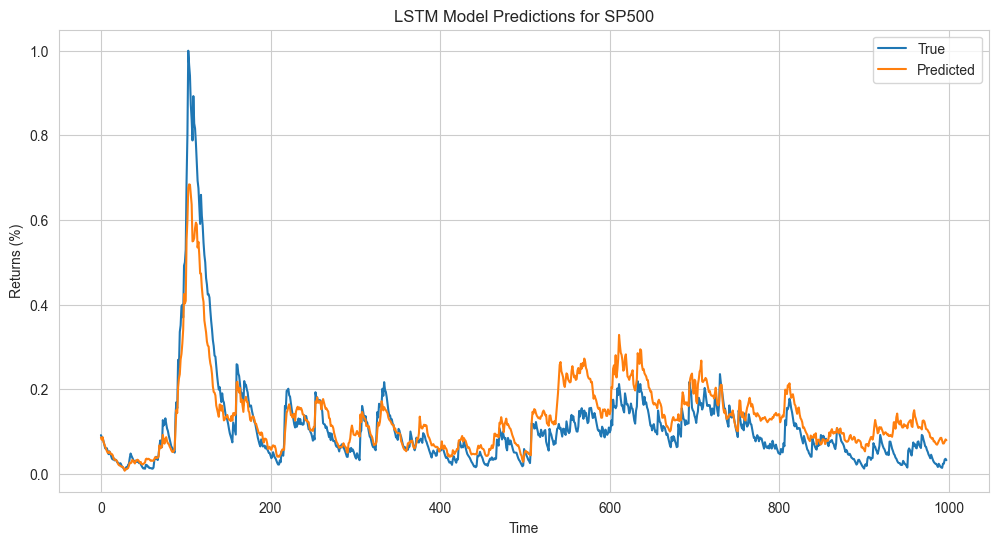

In [31]:
# Evaluate LSTM model for SP500
y_true_sp500, y_pred_sp500, metrics_sp500 = evaluate_model(
    lstm_model_sp500, test_loader_sp500, scaler, -2, -2
)

print("LSTM Model Metrics for SP500:")
for metric, value in metrics_sp500.items():
    print(f"{metric}: {value:.6f}")

# Plot the results
plot_results(y_true_sp500, y_pred_sp500, 'LSTM Model Predictions for SP500')

In [32]:
# Train LSTM model for IBEX35
lstm_model_ibex35 = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model_ibex35.parameters(), lr=0.001)

lstm_model_ibex35, train_losses_ibex35, test_losses_ibex35 = train_model(
    lstm_model_ibex35, train_loader_ibex35, test_loader_ibex35, criterion, optimizer, num_epochs=100
)

Epoch [10/100], Train Loss: 0.000765, Test Loss: 0.004107
Epoch [20/100], Train Loss: 0.000421, Test Loss: 0.002759
Epoch [30/100], Train Loss: 0.000339, Test Loss: 0.002424
Epoch [40/100], Train Loss: 0.000254, Test Loss: 0.001890
Early stopping at epoch 44


LSTM Model Metrics for IBEX35:
MSE: 0.002250
RMSE: 0.047439
MAE: 0.037301
R2: 0.872037


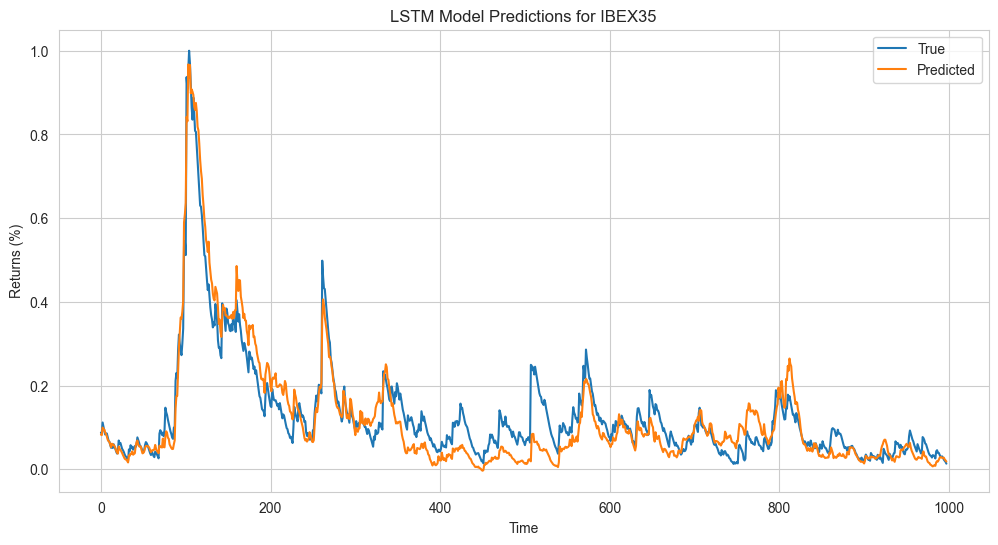

In [33]:
# Evaluate LSTM model for IBEX35
y_true_ibex35, y_pred_ibex35, metrics_ibex35 = evaluate_model(
    lstm_model_ibex35, test_loader_ibex35, scaler, -1, -1
)

print("LSTM Model Metrics for IBEX35:")
for metric, value in metrics_ibex35.items():
    print(f"{metric}: {value:.6f}")

# Plot the results
plot_results(y_true_ibex35, y_pred_ibex35, 'LSTM Model Predictions for IBEX35')

## 9. GRU Model Implementation

Gated Recurrent Unit (GRU) is a type of recurrent neural network that is similar to LSTM but has fewer parameters.

In [34]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        """
        GRU model for time series forecasting.
        
        Parameters:
        input_size (int): Number of features in the input
        hidden_size (int): Number of features in the hidden state
        num_layers (int): Number of recurrent layers
        output_size (int): Number of features in the output
        dropout (float): Dropout probability
        """
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        
        return out

In [35]:
# Train GRU model for SP500
gru_model_sp500 = GRUModel(input_size, hidden_size, num_layers, output_size, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model_sp500.parameters(), lr=0.001)

gru_model_sp500, train_losses_sp500_gru, test_losses_sp500_gru = train_model(
    gru_model_sp500, train_loader_sp500, test_loader_sp500, criterion, optimizer, num_epochs=100
)

Epoch [10/100], Train Loss: 0.000409, Test Loss: 0.002476
Early stopping at epoch 15


GRU Model Metrics for SP500:
MSE: 0.002098
RMSE: 0.045807
MAE: 0.029417
R2: 0.851459


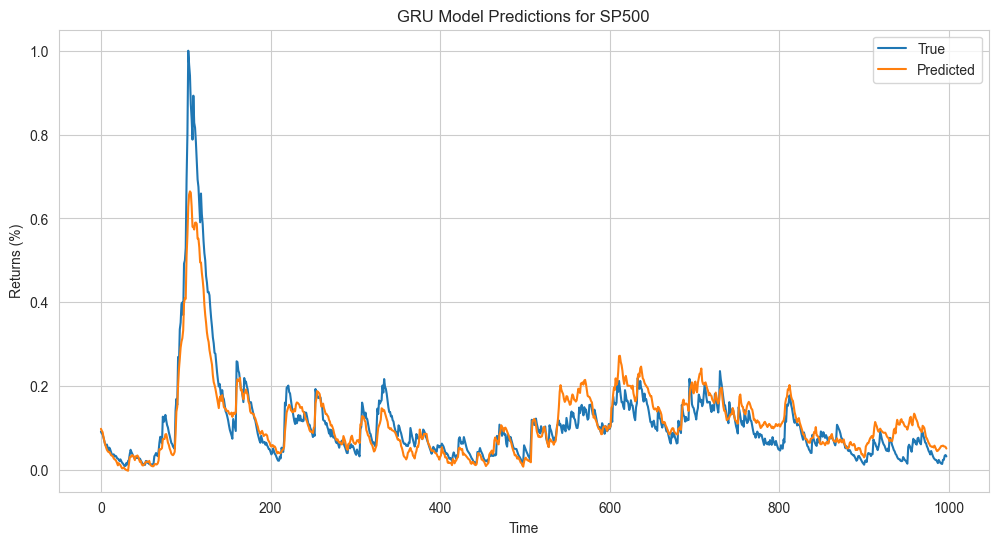

In [36]:
# Evaluate GRU model for SP500
y_true_sp500_gru, y_pred_sp500_gru, metrics_sp500_gru = evaluate_model(
    gru_model_sp500, test_loader_sp500, scaler, -2, -2
)

print("GRU Model Metrics for SP500:")
for metric, value in metrics_sp500_gru.items():
    print(f"{metric}: {value:.6f}")

# Plot the results
plot_results(y_true_sp500_gru, y_pred_sp500_gru, 'GRU Model Predictions for SP500')

In [37]:
# Train GRU model for IBEX35
gru_model_ibex35 = GRUModel(input_size, hidden_size, num_layers, output_size, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model_ibex35.parameters(), lr=0.001)

gru_model_ibex35, train_losses_ibex35_gru, test_losses_ibex35_gru = train_model(
    gru_model_ibex35, train_loader_ibex35, test_loader_ibex35, criterion, optimizer, num_epochs=100
)

Epoch [10/100], Train Loss: 0.000624, Test Loss: 0.002290
Epoch [20/100], Train Loss: 0.000372, Test Loss: 0.002996
Early stopping at epoch 26


GRU Model Metrics for IBEX35:
MSE: 0.001787
RMSE: 0.042271
MAE: 0.029338
R2: 0.898398


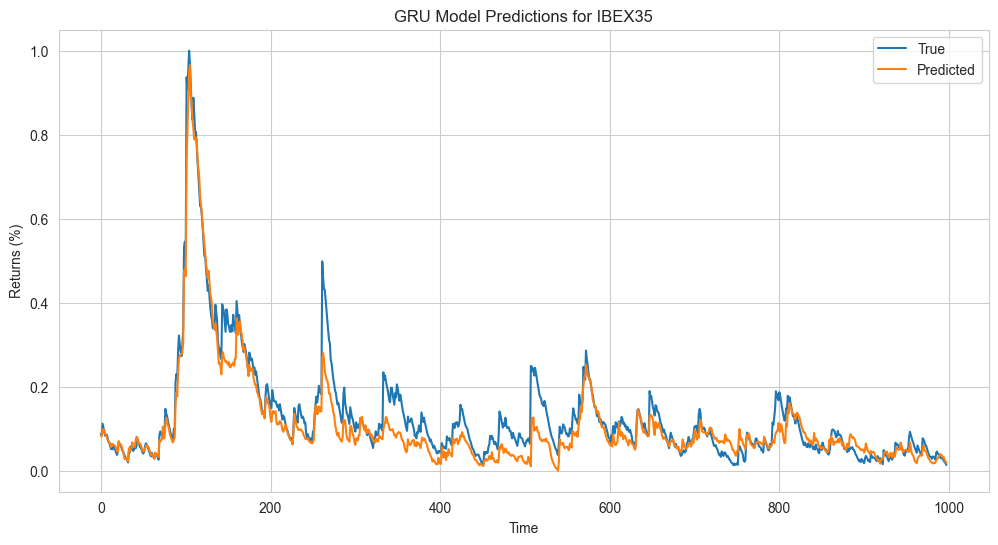

In [38]:
# Evaluate GRU model for IBEX35
y_true_ibex35_gru, y_pred_ibex35_gru, metrics_ibex35_gru = evaluate_model(
    gru_model_ibex35, test_loader_ibex35, scaler, -1, -1
)

print("GRU Model Metrics for IBEX35:")
for metric, value in metrics_ibex35_gru.items():
    print(f"{metric}: {value:.6f}")

# Plot the results
plot_results(y_true_ibex35_gru, y_pred_ibex35_gru, 'GRU Model Predictions for IBEX35')

## 10. RNN Model Implementation

Simple Recurrent Neural Network (RNN) implementation.

In [39]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        """
        RNN model for time series forecasting.
        
        Parameters:
        input_size (int): Number of features in the input
        hidden_size (int): Number of features in the hidden state
        num_layers (int): Number of recurrent layers
        output_size (int): Number of features in the output
        dropout (float): Dropout probability
        """
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        
        return out

In [40]:
# Train RNN model for SP500
rnn_model_sp500 = RNNModel(input_size, hidden_size, num_layers, output_size, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model_sp500.parameters(), lr=0.001)

rnn_model_sp500, train_losses_sp500_rnn, test_losses_sp500_rnn = train_model(
    rnn_model_sp500, train_loader_sp500, test_loader_sp500, criterion, optimizer, num_epochs=100
)

Epoch [10/100], Train Loss: 0.000530, Test Loss: 0.002198
Epoch [20/100], Train Loss: 0.000379, Test Loss: 0.001398
Epoch [30/100], Train Loss: 0.000339, Test Loss: 0.001798
Early stopping at epoch 38


RNN Model Metrics for SP500:
MSE: 0.001438
RMSE: 0.037916
MAE: 0.025719
R2: 0.898232


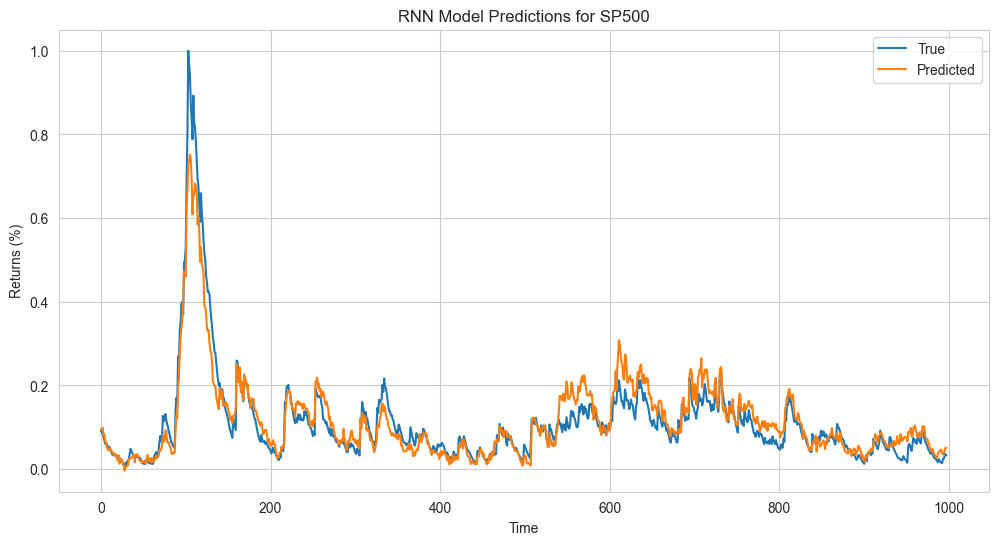

In [41]:
# Evaluate RNN model for SP500
y_true_sp500_rnn, y_pred_sp500_rnn, metrics_sp500_rnn = evaluate_model(
    rnn_model_sp500, test_loader_sp500, scaler, -2, -2
)

print("RNN Model Metrics for SP500:")
for metric, value in metrics_sp500_rnn.items():
    print(f"{metric}: {value:.6f}")

# Plot the results
plot_results(y_true_sp500_rnn, y_pred_sp500_rnn, 'RNN Model Predictions for SP500')

In [42]:
# Train RNN model for IBEX35
rnn_model_ibex35 = RNNModel(input_size, hidden_size, num_layers, output_size, dropout)

criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model_ibex35.parameters(), lr=0.001)

rnn_model_ibex35, train_losses_ibex35_rnn, test_losses_ibex35_rnn = train_model(
    rnn_model_ibex35, train_loader_ibex35, test_loader_ibex35, criterion, optimizer, num_epochs=100
)

Epoch [10/100], Train Loss: 0.001000, Test Loss: 0.004519
Epoch [20/100], Train Loss: 0.000770, Test Loss: 0.002176
Early stopping at epoch 28


RNN Model Metrics for IBEX35:
MSE: 0.002661
RMSE: 0.051585
MAE: 0.038347
R2: 0.848695


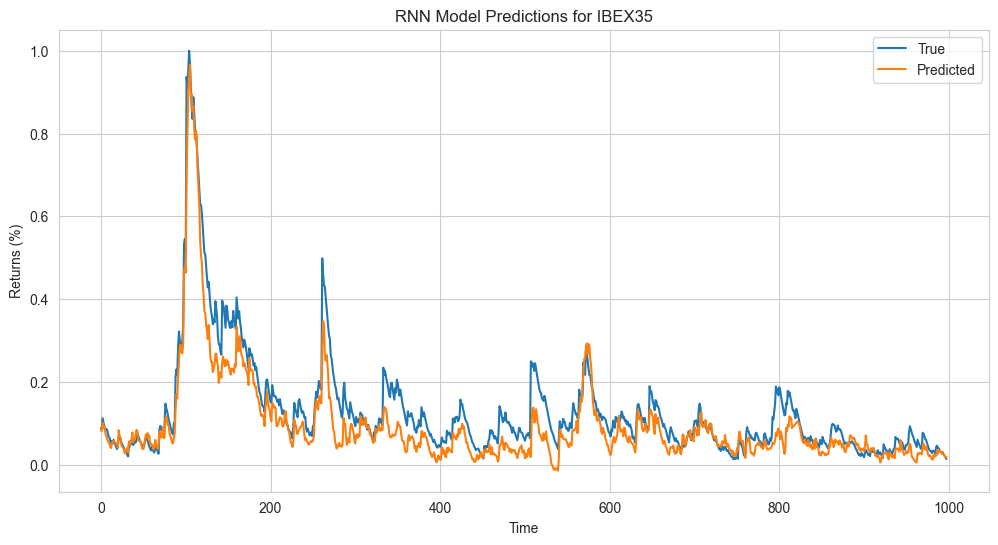

In [43]:
# Evaluate RNN model for IBEX35
y_true_ibex35_rnn, y_pred_ibex35_rnn, metrics_ibex35_rnn = evaluate_model(
    rnn_model_ibex35, test_loader_ibex35, scaler, -1, -1
)

print("RNN Model Metrics for IBEX35:")
for metric, value in metrics_ibex35_rnn.items():
    print(f"{metric}: {value:.6f}")

# Plot the results
plot_results(y_true_ibex35_rnn, y_pred_ibex35_rnn, 'RNN Model Predictions for IBEX35')

## 11. Ensemble Model Implementation

Create an ensemble model by combining the predictions from LSTM, GRU, and RNN models.

In [44]:
# Function to create ensemble predictions
def ensemble_predictions(models, test_loader, scaler, feature_idx, target_idx, weights=None):
    """
    Create ensemble predictions by combining the predictions from multiple models.
    
    Parameters:
    models (list): List of models
    test_loader (torch.utils.data.DataLoader): Testing data loader
    scaler (sklearn.preprocessing.MinMaxScaler): Scaler used to normalize the data
    feature_idx (int): Index of the feature in the original data
    target_idx (int): Index of the target in the original data
    weights (list): List of weights for each model (default: equal weights)
    
    Returns:
    tuple: (y_true, y_pred, metrics)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Set models to evaluation mode
    for model in models:
        model.to(device)
        model.eval()
    
    # Set equal weights if not provided
    if weights is None:
        weights = [1/len(models)] * len(models)
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            
            # Get predictions from each model
            batch_preds = []
            for model in models:
                batch_pred = model(X_batch).cpu().numpy()
                batch_preds.append(batch_pred)
            
            # Combine predictions using weighted average
            ensemble_pred = np.zeros_like(batch_preds[0])
            for i, pred in enumerate(batch_preds):
                ensemble_pred += weights[i] * pred
            
            # Move to CPU for numpy conversion
            y_batch = y_batch.cpu().numpy()
            
            y_true.extend(y_batch)
            y_pred.extend(ensemble_pred)
    
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    return y_true, y_pred, metrics

Ensemble weights for SP500: [0.20501072860796493, 0.32321877903794033, 0.47177049235409474]

Ensemble Model Metrics for SP500:
MSE: 0.001842
RMSE: 0.042916
MAE: 0.028368
R2: 0.869617


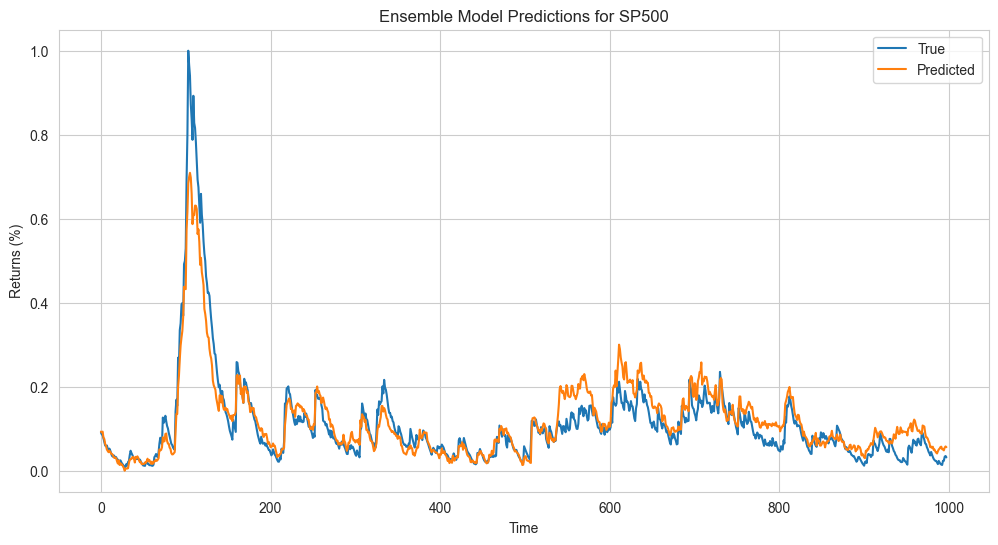

In [45]:
# Create ensemble predictions for SP500
models_sp500 = [lstm_model_sp500, gru_model_sp500, rnn_model_sp500]

# Use weights based on individual model performance (inverse of MSE)
mse_values = [metrics_sp500['MSE'], metrics_sp500_gru['MSE'], metrics_sp500_rnn['MSE']]
weights = [1/mse for mse in mse_values]
weights = [w/sum(weights) for w in weights]  # Normalize weights

print(f"Ensemble weights for SP500: {weights}")

y_true_sp500_ensemble, y_pred_sp500_ensemble, metrics_sp500_ensemble = ensemble_predictions(
    models_sp500, test_loader_sp500, scaler, -2, -2, weights=weights
)

print("\nEnsemble Model Metrics for SP500:")
for metric, value in metrics_sp500_ensemble.items():
    print(f"{metric}: {value:.6f}")

# Plot the results
plot_results(y_true_sp500_ensemble, y_pred_sp500_ensemble, 'Ensemble Model Predictions for SP500')

Ensemble weights for IBEX35: [0.32204192545451904, 0.4055980087683343, 0.2723600657771466]

Ensemble Model Metrics for IBEX35:
MSE: 0.001527
RMSE: 0.039071
MAE: 0.028002
R2: 0.913201


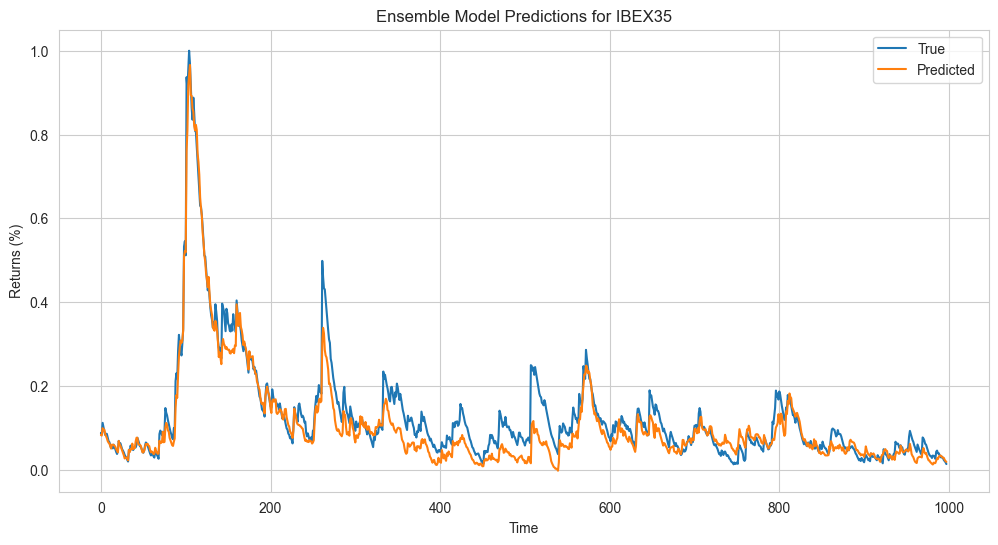

In [46]:
# Create ensemble predictions for IBEX35
models_ibex35 = [lstm_model_ibex35, gru_model_ibex35, rnn_model_ibex35]

# Use weights based on individual model performance (inverse of MSE)
mse_values = [metrics_ibex35['MSE'], metrics_ibex35_gru['MSE'], metrics_ibex35_rnn['MSE']]
weights = [1/mse for mse in mse_values]
weights = [w/sum(weights) for w in weights]  # Normalize weights

print(f"Ensemble weights for IBEX35: {weights}")

y_true_ibex35_ensemble, y_pred_ibex35_ensemble, metrics_ibex35_ensemble = ensemble_predictions(
    models_ibex35, test_loader_ibex35, scaler, -1, -1, weights=weights
)

print("\nEnsemble Model Metrics for IBEX35:")
for metric, value in metrics_ibex35_ensemble.items():
    print(f"{metric}: {value:.6f}")

# Plot the results
plot_results(y_true_ibex35_ensemble, y_pred_ibex35_ensemble, 'Ensemble Model Predictions for IBEX35')

## 12. Compare Model Performance

Model Performance Comparison for SP500:
               MSE      RMSE       MAE        R2
LSTM      0.003308  0.057517  0.041459  0.765811
GRU       0.002098  0.045807  0.029417  0.851459
RNN       0.001438  0.037916  0.025719  0.898232
Ensemble  0.001842  0.042916  0.028368  0.869617


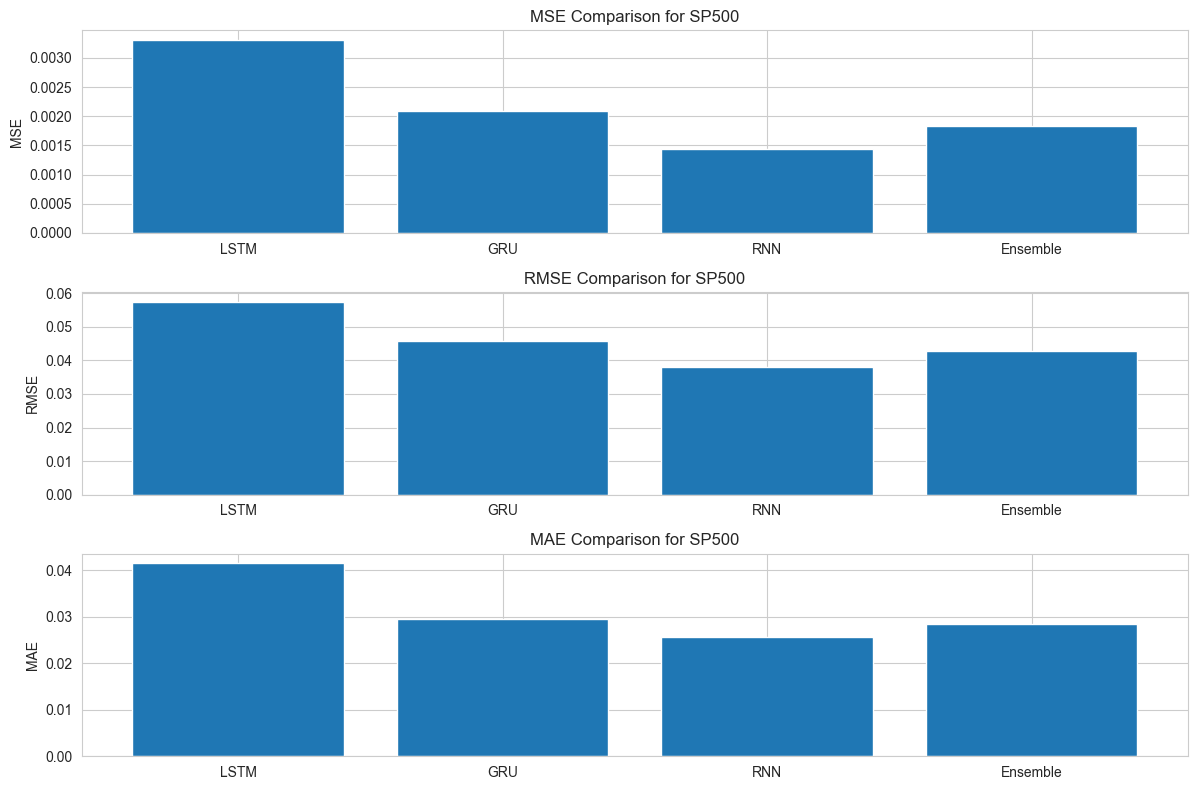

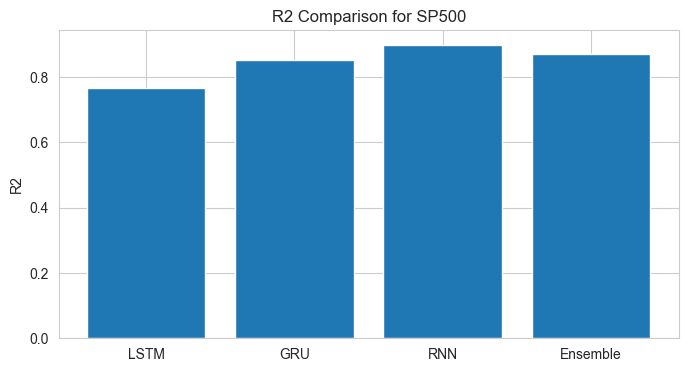

In [47]:
# Compare model performance for SP500
models_sp500_names = ['LSTM', 'GRU', 'RNN', 'Ensemble']
metrics_list_sp500 = [metrics_sp500, metrics_sp500_gru, metrics_sp500_rnn, metrics_sp500_ensemble]

# Create a DataFrame for comparison
comparison_sp500 = pd.DataFrame(index=models_sp500_names)
for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
    comparison_sp500[metric] = [metrics[metric] for metrics in metrics_list_sp500]

print("Model Performance Comparison for SP500:")
print(comparison_sp500)

# Plot the comparison
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['MSE', 'RMSE', 'MAE']):
    plt.subplot(3, 1, i+1)
    plt.bar(models_sp500_names, comparison_sp500[metric])
    plt.title(f'{metric} Comparison for SP500')
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

# Plot R2 separately (higher is better)
plt.figure(figsize=(8, 4))
plt.bar(models_sp500_names, comparison_sp500['R2'])
plt.title('R2 Comparison for SP500')
plt.ylabel('R2')
plt.show()

Model Performance Comparison for IBEX35:
               MSE      RMSE       MAE        R2
LSTM      0.002250  0.047439  0.037301  0.872037
GRU       0.001787  0.042271  0.029338  0.898398
RNN       0.002661  0.051585  0.038347  0.848695
Ensemble  0.001527  0.039071  0.028002  0.913201


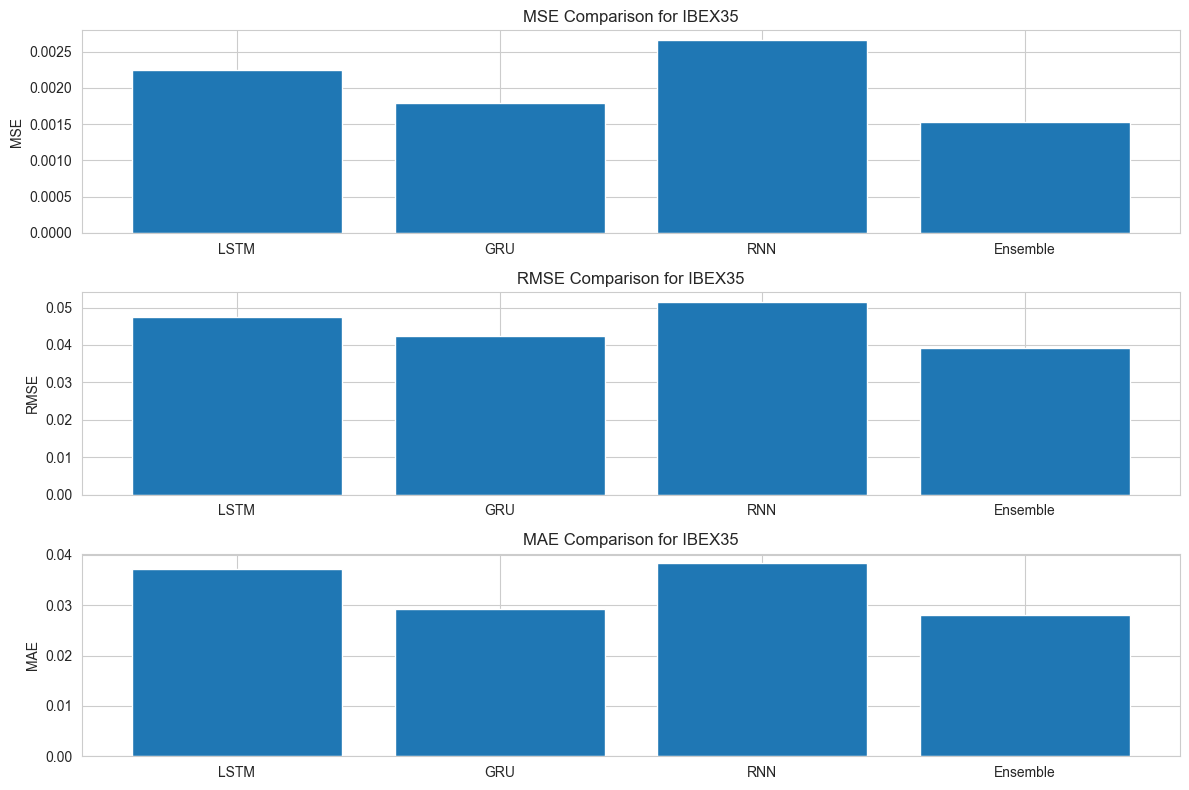

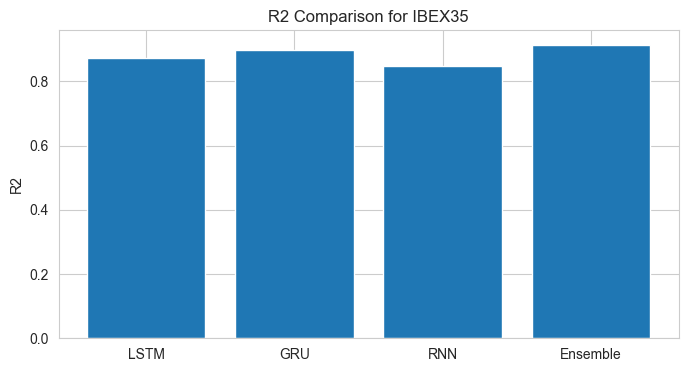

In [48]:
# Compare model performance for IBEX35
models_ibex35_names = ['LSTM', 'GRU', 'RNN', 'Ensemble']
metrics_list_ibex35 = [metrics_ibex35, metrics_ibex35_gru, metrics_ibex35_rnn, metrics_ibex35_ensemble]

# Create a DataFrame for comparison
comparison_ibex35 = pd.DataFrame(index=models_ibex35_names)
for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
    comparison_ibex35[metric] = [metrics[metric] for metrics in metrics_list_ibex35]

print("Model Performance Comparison for IBEX35:")
print(comparison_ibex35)

# Plot the comparison
plt.figure(figsize=(12, 8))
for i, metric in enumerate(['MSE', 'RMSE', 'MAE']):
    plt.subplot(3, 1, i+1)
    plt.bar(models_ibex35_names, comparison_ibex35[metric])
    plt.title(f'{metric} Comparison for IBEX35')
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

# Plot R2 separately (higher is better)
plt.figure(figsize=(8, 4))
plt.bar(models_ibex35_names, comparison_ibex35['R2'])
plt.title('R2 Comparison for IBEX35')
plt.ylabel('R2')
plt.show()

## 13. Save Models for Streamlit App

In [49]:
# Create a directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Function to save a model
def save_model(model, filename):
    """
    Save a PyTorch model.
    
    Parameters:
    model (torch.nn.Module): Model to save
    filename (str): Filename to save the model to
    """
    torch.save(model.state_dict(), filename)
    print(f"Model saved to {filename}")

# Save SP500 models
save_model(lstm_model_sp500, 'models/lstm_sp500.pth')
save_model(gru_model_sp500, 'models/gru_sp500.pth')
save_model(rnn_model_sp500, 'models/rnn_sp500.pth')

# Save IBEX35 models
save_model(lstm_model_ibex35, 'models/lstm_ibex35.pth')
save_model(gru_model_ibex35, 'models/gru_ibex35.pth')
save_model(rnn_model_ibex35, 'models/rnn_ibex35.pth')

# Save model parameters for later use
model_params = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'dropout': dropout,
    'seq_length': seq_length,
    'feature_columns': df.columns.tolist(),
    'ensemble_weights_sp500': weights,
    'ensemble_weights_ibex35': weights,
    'target_idx_sp500': -2,
    'target_idx_ibex35': -1
}

with open('models/model_params.pkl', 'wb') as f:
    pickle.dump(model_params, f)
print("Model parameters saved to models/model_params.pkl")

# Save scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved to models/scaler.pkl")

# Save feature columns
with open('models/feature_columns.pkl', 'wb') as f:
    pickle.dump(df.columns.tolist(), f)
print("Feature columns saved to models/feature_columns.pkl")

Model saved to models/lstm_sp500.pth
Model saved to models/gru_sp500.pth
Model saved to models/rnn_sp500.pth
Model saved to models/lstm_ibex35.pth
Model saved to models/gru_ibex35.pth
Model saved to models/rnn_ibex35.pth
Model parameters saved to models/model_params.pkl
Scaler saved to models/scaler.pkl
Feature columns saved to models/feature_columns.pkl


## 14. Conclusion

In this notebook, we have implemented LSTM, GRU, and RNN models to predict the future prices of SP500 and IBEX35 indices. We have enhanced our models with economic indicators, technical analysis features, and seasonality decomposition. We have also created an ensemble model by combining the predictions from these models. The models have been saved for later use in the Streamlit app.